In [ ]:
#THIS SCRIPT WILL MAKE INTEGRATED SEURAT OBJECT WITH STANDARD WORKFLOW, WITHOUT PROTOPLAST INDUCED 
#GENES, OR MITO/CP GENES IN THE VARIABLE FEATURE LIST
#THIS ONLY LOOKS AT WT INTEGRATED

In [ ]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
if (!requireNamespace("here", quietly = TRUE))
    install.packages("here")
if (!requireNamespace("ggplot2", quietly = TRUE))
    install.packages("ggplot2")
if (!requireNamespace("ggpointdensity", quietly = TRUE))
    install.packages("ggpointdensity")
if (!requireNamespace("DropletUtils", quietly = TRUE)) 
    BiocManager::install("DropletUtils")
if (!requireNamespace("BUSpaRse", quietly = TRUE)) 
    BiocManager::install("BUSpaRse")
if (!requireNamespace("scico", quietly = TRUE))
    install.packages("scico")
if (!requireNamespace("reticulate", quietly = TRUE))
    install.packages("reticulate")
if (!requireNamespace("future", quietly = TRUE))
    install.packages("future")
if (!requireNamespace("DoubletFinder", quietly = TRUE))
    remotes::install_github('chris-mcginnis-ucsf/DoubletFinder')
if (!requireNamespace("tidyverse", quietly = TRUE))
    install.packages("tidyverse")
#devtools::install_github(repo = 'satijalab/seurat', ref = 'develop')
# if (!requireNamespace("COPILOT", quietly = TRUE))
#     devtools::install_github('Hsu-Che-Wei/COPILOT')

In [ ]:
library(BUSpaRse)
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scico)
library(scales)
library(DropletUtils)
library(reticulate)
library(repr)
library(DoubletFinder)
library(future)
options(future.globals.maxSize = 100000 * 1024^2)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 4,]$genes)

In [2]:
wt_1_seu = readRDS(file = "../data/seurat1/sc_26_seu_1.rds")
wt_2_seu = readRDS(file = "../data/seurat1/sc_67_seu_1.rds")
mut_1_seu = readRDS(file = "../data/seurat1/sc_27_seu_1.rds")
mut_2_seu = readRDS(file = "../data/seurat1/sc_68_seu_1.rds")

In [23]:
wt_intd_std = std_integrate(wt_1_seu, wt_2_seu, filename = "std_intd_wt_2_minus_protos", nfeatures = 3000)

Warning message in CheckDuplicateCellNames(object.list = object.list):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 15459 anchors

Filtering anchors

	Retained 10827 anchors

Extracting within-dataset neighbors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
"Adding a command log without an assay associated with it"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16177
Number of edges: 506702

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9034
Number of communities: 16
Elapsed time: 2 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
18:06:10 UMAP embedding parameters a = 0.9922 b = 1.112

18:06:10 Read 16177 rows and found 30 numeric columns

18:06:10 Using Annoy for neighbor search, n_neighbors = 30

18:06:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

18:06:14 Writing NN index file to temp file /tmp/RtmpaL6lB4/file128a44e0d8c

18:06:14 Searching Annoy index using 1 thread, search_k = 3000

18:06:21 Annoy recall = 100%

18:06:22 Commencing smooth kNN distance calibration using 1 thread

18:06:25 Initializing fr

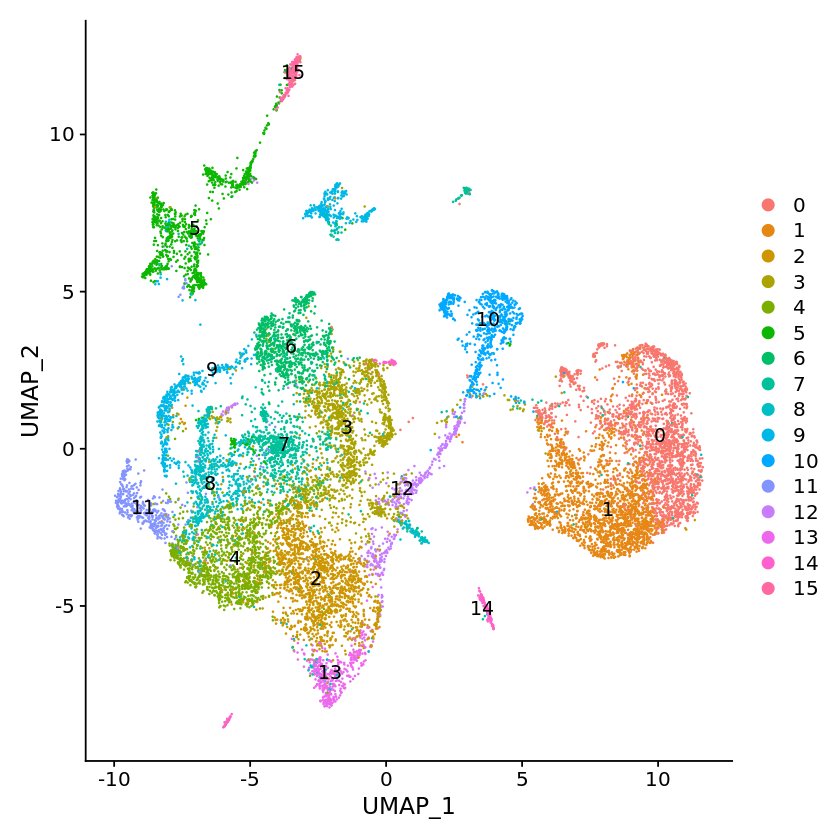

In [24]:
DefaultAssay(wt_intd_std) <- "integrated"

# Run the standard workflow for visualization and clustering
wt_intd_std <- ScaleData(wt_intd_std, verbose = FALSE)
wt_intd_std <- RunPCA(wt_intd_std, npcs = 30, verbose = FALSE)
wt_intd_std <- FindNeighbors(wt_intd_std, dims = 1:10)
wt_intd_std <- FindClusters(wt_intd_std, resolution = 0.5)
wt_intd_std <- RunUMAP(wt_intd_std, reduction = "pca", dims = 1:30)
DimPlot(wt_intd_std, reduction = "umap", label = TRUE)

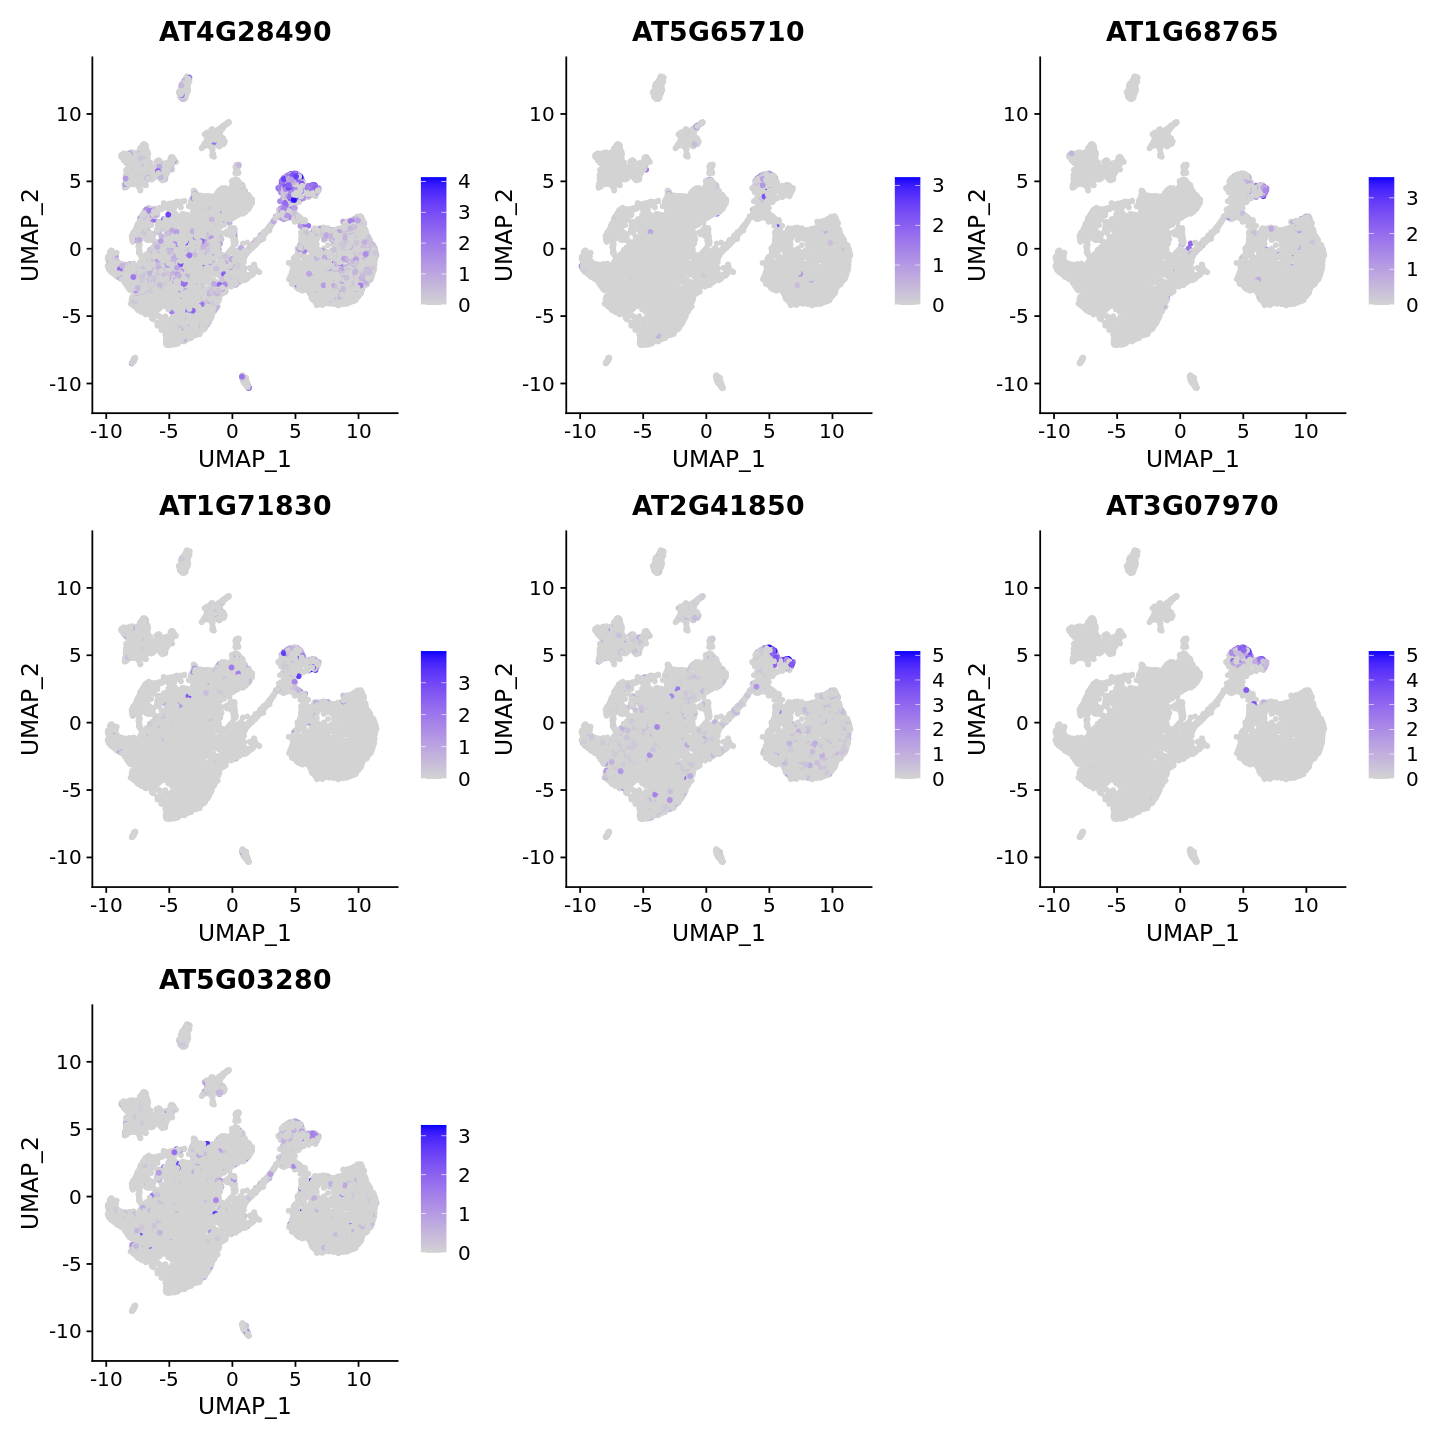

In [25]:
options(repr.plot.width=12, repr.plot.height=12)
wt_intd_std@active.assay = "RNA"
FeaturePlot(wt_intd_std, features = c("AT4G28490", "AT5G65710","AT1G68765", "AT1G71830","AT2G41850", "AT3G07970", "AT5G03280"), pt.size = 1.0)

In [3]:
#takes a list of Seurat objects and performs standard integration
std_integrate <- function(..., filename, nfeatures) {
    obj.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    for (i in 1:length(obj.list)) {
        obj.list[[i]] <- NormalizeData(obj.list[[i]], verbose = FALSE)
        obj.list[[i]] <- FindVariableFeatures(obj.list[[i]], selection.method = "vst", nfeatures = nfeatures, verbose = FALSE)
        VariableFeatures(obj.list[[i]]) <-  VariableFeatures(obj.list[[i]])[!(VariableFeatures(obj.list[[i]]) %in% proto_list)]
    }
    
    rc.anchors <- FindIntegrationAnchors(object.list = obj.list, dims = 1:30)
    rc.integrated <- IntegrateData(anchorset = rc.anchors, dims = 1:30)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
}
